In [2]:
import logging
import os
import cv2
import time
import datetime
import random
from os.path import join, dirname

import pandas as pd
import numpy as np
import hydra
import wandb
from tqdm import tqdm
from omegaconf import DictConfig
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import csv

from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
from src.factories.model_factory import get_model
from src.factories.dataset_factory import get_dataset
from src.utils.path_names import raw_episodes_path, obs_frames_path

In [5]:
import gfootball.env as football_env
from gfootball.env import observation_preprocessing, wrappers
from gfootball.env.wrappers import Simple115StateWrapper
import numpy as np
import pickle
from gfootball.env.wrappers import Simple115StateWrapper

### Creating the dataset from 4800 replay files

In [79]:
# !!!!!!!!!!!!!!!!!!! Do not delete this cell !!!!!!!!!!!!!!!!!!!

# replay_files_path = '../replay_files'
# replay_files = sorted(os.listdir(replay_files_path))
# replay_files.pop(0)
# len(replay_files)

In [80]:
# Here we will write the pickle files
def prepare_pkl_dataset_from_replay_files(replay_files):
    pkld_obs_save_dir = '../dataset/pickled_files'
    replay_files_path = '../replay_files'
    frame_no_csv_file = '../dataset/frames.csv'
    with open(frame_no_csv_file, 'w') as frames_csv:
        frames_csv_writer = csv.writer(frames_csv)
        for replay in tqdm(replay_files):
            # print(f"Processing replay file: {replay}")
            with open(os.path.join(replay_files_path, replay), 'rb') as pkl_file:
                episode_data = pickle.load(pkl_file)
            episode_no = replay.split('.')[0]
            episode = episode_data['observations']
            episode['active'] = episode_data['players'][0]['active']
            episode_length = 3002
            raw_obs = {}
            float115_frames = []
            for step in range(episode_length):
                for (key, item) in episode.items():
                    raw_obs[key] = item[step]

                float115_frame =  Simple115StateWrapper.convert_observation([raw_obs], True)[0].tolist()
                action = episode_data['players'][0]['action'][step]
                
                frame_name = episode_no+f'_{step}'
                if len(action) != 0:
                    float115_frame.extend(action)
                    float115_frame.insert(0, frame_name)
                    float115_frames.append(float115_frame)
                    frames_csv_writer.writerow([frame_name])
                    # pkl_obs_file_path = os.path.join(pkld_obs_save_dir, episode_no + '_' + str(step)) 
            # float115_frames.insert(0, frame_name)
            with open(os.path.join(pkld_obs_save_dir, replay), 'wb') as handle:
                pickle.dump(float115_frames, handle)
#     return float115_frames

In [81]:
# def prepare_dataset_from_replay_files(replay_files, train=True):
#     no_of_csv_files = 20
#     trajectories_in_each_file = len(replay_files) // no_of_csv_files # (3360/40)*3001 trajectories in each file
#     replay_files_path = '../replay_files'
# #         float115_frames = []
#     csv_file_counter = 0
#     if train:
#         csv_files_path = '../dataset/train'
#     else:
#         csv_files_path = '../dataset/test'                             
#     for (file_no, replay) in tqdm(enumerate(replay_files)):
#         with open(os.path.join(replay_files_path, replay), 'rb') as pkl_file:
#             episode_data = pickle.load(pkl_file)
            
#         if file_no % trajectories_in_each_file == 0:
#             obs_csv_file_name = 'test_replay_' + f"_{str(csv_file_counter)}.csv"
#             csv_file_counter += 1
            
#         with open(os.path.join(csv_files_path, obs_csv_file_name), 'a') as obs_csv_file:
#             obs_csv_writer = csv.writer(obs_csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

#             episode = episode_data['observations']
#             episode['active'] = episode_data['players'][0]['active']

#             episode_length = 3002
#             raw_obs = {}

#             for step in range(episode_length):
#                 for (key, item) in episode.items():
#                     raw_obs[key] = item[step]

#                 float115_frame =  Simple115StateWrapper.convert_observation([raw_obs], True)[0].tolist()
#                 action = episode_data['players'][0]['action'][step]
#                 float115_frame.extend(action)
#                 if len(action) != 0:
#     #                     float115_frames.append(float115_frame)
#                     obs_csv_writer.writerow(float115_frame)
# #         return float115_frames

In [82]:
# TODO: DO NOT DELETE
# %time prepare_pkl_dataset_from_replay_files(replay_files)

### Loading the Dataset using torch

In [6]:
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [28]:
class Float115Dataset(Dataset):

    def __init__(self, data, path = None, transform=None):
        self.data = data
        self.transform = transform
        self.path = path

    def __getitem__(self, idx):
        obs_frame_name = self.data[idx]
        pkl_file_prefix = obs_frame_name.split('_')[0]
        pkl_file_path = os.path.join(self.path, pkl_file_prefix, f"{obs_frame_name}.p")
        
        try:
            with open(pkl_file_path, 'rb') as pkl_file:
                obs_with_action = pickle.load(pkl_file)
        except ValueError:
            print(f"The file {pkl_file_path} was not found in the directory")
        obs = np.array(obs_with_action[0:115])
        action = obs_with_action[115]
        return obs, int(action)

    def __len__(self):
        return len(self.data)

### Training a model

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [30]:
# obs_df = pd.DataFrame(pd.read_pickle('../dataset/pickled_files/3720620.p')).set_index(0)
# obs_df.head()

# frames_df = pd.read_csv('../dataset/frames.csv', header=None)
# frames_df.head()

In [31]:
# TODO: DO not delete it
dataset = list(pd.read_csv('../dataset/frames.csv', header=None)[0])
len(dataset)

14404800

In [51]:
train, test = train_test_split(dataset[0:10000], test_size=0.30, random_state=42)
len(train), len(test)

(7000, 3000)

In [52]:
train_dataset, test_dataset = Float115Dataset(train, '../dataset/single_obs_pkl_files'), Float115Dataset(test, '../dataset/single_obs_pkl_files')
len(train_dataset), len(test_dataset)

(7000, 3000)

In [53]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True, num_workers=0)

In [54]:
class MLPModel(nn.Module):
    """
    Take float115_v2 (115 dimension vector) as input
    """

    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(115, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.actor = nn.Linear(256, 19)
        self.critic = nn.Linear(256, 1)

    def forward(self, x):
        x = self.mlp(x)
        logits = self.actor(x)
#         print(logits.shape, logits.sum(dim=1).shape, logits.sum(dim=1), logits)
        return logits

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel()
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
criterion = nn.CrossEntropyLoss()

In [56]:
# wandb.init(project="GRF_imitation_learning")
# wandb.watch(model)

### Use Tensorboard

In [57]:
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [60]:
def train_model(num_epochs):
    train_loss_values = []
    eval_loss_values = []
    training_accuracy = []
    for epoch in range(num_epochs):
        start_time = time.time()
        correct = 0
        correct_eval_samples = 0
        epoch_loss = 0
        eval_loss = 0
        running_train_loss = 0.0
        running_eval_loss = 0.0

        # Train 
        model.train()
        for i, (x, y) in enumerate(tqdm(train_loader)):
            x = torch.as_tensor(x, device=device, dtype=torch.float32)
            y = torch.as_tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.long())
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optim.step()
            pred = torch.argmax(z, dim=1)
            if (i+1) % 10 == 0:
                print(f"train loss: {loss.item()}", end='\n')
            correct += (pred.cpu() == y.long().cpu()).sum()
            running_train_loss += loss.item() * x.shape[0]
        epoch_accuracy = correct/len(train_dataset)
        epoch_loss = running_train_loss / len(train_dataset)
        train_loss_values.append(epoch_loss)
        training_accuracy.append(epoch_accuracy)

            # Eval
        model.eval()
        with torch.no_grad():
            for i, (x, y) in enumerate(test_loader):
                x = torch.as_tensor(x, device=device, dtype=torch.float32)
                y = torch.as_tensor(y, device=device, dtype=torch.float32)
                z = model(x)
                loss = criterion(z, y.long())
                running_eval_loss += loss.item() * x.shape[0]
                writer.add_scalar('Loss/test', eval_loss, epoch)
        eval_loss = running_eval_loss / len(test_dataset)
        eval_loss_values.append(eval_loss)
        print('Epoch {:03}/{}: | Train Loss: {:.3f} | Eval Loss: {:.3f} | Epoch accuracy: {:.2f} | Training time: {}'.format(epoch + 1, num_epochs, epoch_loss, eval_loss, epoch_accuracy, str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
#             plt.plot(train_loss_values)
        # wandb.log({'train loss': epoch_loss, 'val loss': eval_loss})
    return train_loss_values, eval_loss_values, training_accuracy

In [61]:
train_loss_values, eval_loss_values, training_accuracy = train_model(1)
writer.flush()

10it [00:05,  1.79it/s]

train loss: 1.6971852779388428


20it [00:11,  1.60it/s]

train loss: 1.5629863739013672


30it [00:17,  1.75it/s]

train loss: 1.4489463567733765


33it [00:20,  1.58it/s]


KeyboardInterrupt: 

In [83]:
# Just a sanity check
len(train_loss_values), len(eval_loss_values), len(training_accuracy)

(10, 10, 10)

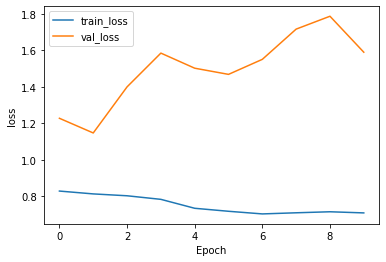

In [84]:
plt.plot(train_loss_values, label='train_loss')
plt.plot(eval_loss_values, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
# plt.show()
plt.savefig('imitation.jpg')

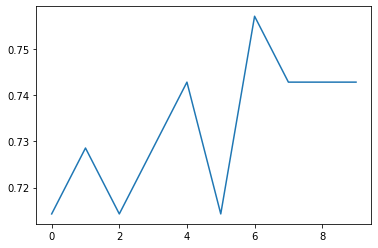

In [85]:
plt.plot(training_accuracy)
plt.show()

In [21]:
writer.close()

NameError: name 'writer' is not defined

In [1]:

!tensorboard --logdir=runs

Traceback (most recent call last):
  File "/home/ssk/.local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/home/ssk/.local/lib/python3.6/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/home/ssk/.local/lib/python3.6/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/home/ssk/.local/lib/python3.6/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 25, in <module>
    from tensorboard.data import provider
  File "/home/ssk/.local/lib/python3.6/site-packages/tensorboard/data/__init__.py", line 17, in <module>
    from tensorboard.data import experimental  # noqa: F401
  File "/home/ssk/.local/lib/python3.6/site-packages/tensorboard/data/experimental/__init__.py", line 17, in <module>
    from tensorboard.data.experimental.experiment_from_dev import (  # noqa: F401
  File "/home/ssk/.local/lib/python3.6/site-packa

### Reading from the JSON file

In [ ]:
import json

In [ ]:
epi_file = open("replays/3865031.json")

episode_data = json.load(epi_file)

In [ ]:
episode_data.keys()

In [ ]:
episode_data['steps'][30][0]['observation']['players_raw'][0].keys()

In [ ]:
episode_data['steps'][0][0]['observation']['players_raw'][0].keys()

In [ ]:
step = 0 # total 3002 steps: 0.....3001
episode_data['steps'][step][0]['observation']['players_raw'][0]

In [ ]:
data['steps'][3001][0]['action']

### Other experiments

In [ ]:
import numpy as np
np.random.rand(3,2)

In [ ]:
a = np.random.rand(1, 116)

In [ ]:
type(a), a.dtype

In [ ]:
from sys import getsizeof

In [ ]:
print(f"{(a.nbytes/1000000) * (4800*3001) / 1000} GB")

In [ ]:
14,404,800


In [ ]:
os.listdir()

In [ ]:
import csv
a = ['apple', 'orange', 'banana']
print(a)
with open("output.csv", "wb") as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(a)

In [ ]:
['Spam'] * 5 + ['Baked Beans']

In [ ]:
os.listdir()

In [ ]:
import csv
a = [1, 2, 3, 4, 5]
with open('eggs.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
    spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

In [122]:
from distributed import Client

In [125]:
# from dask.distributed import Client

# # Scale up: connect to your own cluster with more resources
# # see http://dask.pydata.org/en/latest/setup.html
# client = Client(processes=False, threads_per_worker=4,
#                 n_workers=1, memory_limit='2GB')
# client

In [4]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [13]:
X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(1000000, 2), dtype=float64, chunksize=(100000, 2), chunktype=numpy.ndarray>

In [19]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

IndexError: Too many indices for array

In [43]:
import csv

In [72]:
csv_files_train = os.listdir('../dataset/train')

In [74]:
with open ('../dataset/train.csv', 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    for file in tqdm(csv_files_train):
        obs_arr = np.array(pd.read_csv(os.path.join('../dataset/train', file)))
        csv_writer.writerows(obs_arr)


100%|██████████| 40/40 [27:29<00:00, 41.24s/it]


In [68]:
csv_a = np.array(pd.read_csv('../dataset/train/train_replay__0.csv'))
csv_b = np.array(pd.read_csv('../dataset/train/train_replay__1.csv'))

In [69]:
with open ('test.csv', 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(csv_a)
    csv_writer.writerows(csv_b)

In [70]:
test_csv = pd.read_csv('test.csv')

In [71]:
test_csv.shape

(504165, 116)

In [98]:
rand_list = [random.random() for i in tqdm(range(4800*3001))]

100%|██████████| 14404800/14404800 [00:03<00:00, 3792540.55it/s]


In [99]:
len(rand_list)

14404800

In [100]:
a = np.array(rand_list)

In [101]:
a.shape, a.nbytes/1000000

((14404800,), 115.2384)

In [106]:
replay_files_path = '../replay_files'
replay_files = os.listdir(replay_files_path)
replay_files.pop(0)

'.gitkeep'

In [111]:
obs_list = []
for replay_file_name in replay_files:
    for step in range(3001):
        frame = replay_file_name.split('.')[0] + f'_{step}'
        obs_list.append(frame)

In [112]:
len(obs_list)

14404800

In [113]:
obs_list

['3720620_0',
 '3720620_1',
 '3720620_2',
 '3720620_3',
 '3720620_4',
 '3720620_5',
 '3720620_6',
 '3720620_7',
 '3720620_8',
 '3720620_9',
 '3720620_10',
 '3720620_11',
 '3720620_12',
 '3720620_13',
 '3720620_14',
 '3720620_15',
 '3720620_16',
 '3720620_17',
 '3720620_18',
 '3720620_19',
 '3720620_20',
 '3720620_21',
 '3720620_22',
 '3720620_23',
 '3720620_24',
 '3720620_25',
 '3720620_26',
 '3720620_27',
 '3720620_28',
 '3720620_29',
 '3720620_30',
 '3720620_31',
 '3720620_32',
 '3720620_33',
 '3720620_34',
 '3720620_35',
 '3720620_36',
 '3720620_37',
 '3720620_38',
 '3720620_39',
 '3720620_40',
 '3720620_41',
 '3720620_42',
 '3720620_43',
 '3720620_44',
 '3720620_45',
 '3720620_46',
 '3720620_47',
 '3720620_48',
 '3720620_49',
 '3720620_50',
 '3720620_51',
 '3720620_52',
 '3720620_53',
 '3720620_54',
 '3720620_55',
 '3720620_56',
 '3720620_57',
 '3720620_58',
 '3720620_59',
 '3720620_60',
 '3720620_61',
 '3720620_62',
 '3720620_63',
 '3720620_64',
 '3720620_65',
 '3720620_66',
 '372

### Machine Learning with Dask